*Version: 28.01.2023*

<a href="https://www.w-hs.de/service/informationen-zur-person/person/nalbach/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png"       alt="drawing" width="200" align="right"/>
</a>

<h1 align="center">  </h1>
<h1 align="center"> Maschine Learning 1 WS 22/23 </h1>
<h4 align="center"> Lennart Fuhrig </h4>


> Training of a single [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to evaluate its **Probabilistic Classification** capability via the `predict_proba` function

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from ipynb.fs.full.header_file import get_processed_data, plot_MRF

2023-01-28 14:53:48.655730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 14:53:48.757694: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lennart/catkin_ws/devel/lib:/home/lennart/ws_moveit/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2023-01-28 14:53:48.757706: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-28 14:53:49.203584: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:

In [2]:
# call preprocessing function
train_data, unique_data, overlap_data, test_data, class_dict = get_processed_data(proportion=0.2, debug=True)

1. load CIFAR-10 dataset:

train:	(50000, 32, 32, 3), (50000, 1)
test:	(10000, 32, 32, 3), (10000, 1)

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

2. preprocess dataset:

train:	(50000, 1024), (50000,)
test:	(10000, 1024), (10000, 1024)

3. prepare train data for ensemble:

unique:	(40000, 1024), (40000,)
overlap:(10000, 1024), (10000,)


In [3]:
# define random forest base classifier with parameters determined by GridSearchCV
def rf_base_clf():
    return RandomForestClassifier(n_estimators=100, 
                                  min_samples_leaf=2, 
                                  max_features=None, 
                                  max_depth=None, 
                                  verbose=0)

In [4]:
# only for develop

develop = False

if develop:

    samples = 200
    test_data[0] = test_data[0][:samples]
    test_data[1] = test_data[1][:samples]

    samples = 200
    train_data[0] = train_data[0][:samples]
    train_data[1] = train_data[1][:samples]

In [5]:
# create the base classifier
one_rf = rf_base_clf()

In [6]:
# fit rf on dataset
one_rf.fit(train_data[0], train_data[1])

RandomForestClassifier(max_features=None, min_samples_leaf=2)

In [7]:
def evaluation(labels, ensemble_pred, ensemble_pred_confi, treshold):

    N, M, R, F = len(labels), 0, 0, 0

    # iterate over all images 
    for label, pred, o_max in zip(labels, ensemble_pred, ensemble_pred_confi):    

        # is the prediction subject to uncertainty? 
        if o_max < treshold: 
            M += 1

            # is the uncertain prediction right or wrong?
            if pred == label: R += 1
            else: F += 1
                
    if M != 0:
        # relativize values to N (number of images) (R, F already relative to M)
        M = M / N
        R = R / N
        F = F / N 
            
    return [M, R, F, treshold]

In [8]:
# create horizontal axis
treshold_range = (np.round(np.arange(0, 1.05, 0.05), 2)) 

def main(data, data_name):
    
    # extract images and labels from given data set
    images, labels = data[0], data[1]
    
    # evaluate RF on given dataset
    acc = one_rf.score(images, labels)
    pred = one_rf.predict(images)
    relative_pred = one_rf.predict_proba(images)
    ensemble_pred = np.asarray([np.argmax(pred) for pred in relative_pred])
    ensemble_pred_confi =  np.asarray([np.max(pred) for pred in relative_pred])
    
    # print evaluation info
    print(f'accuracy:\t\t{round(acc, 3)}\t\t{type(acc)}')
    print(f'predictions:\t\t{pred.shape}\t\t{type(pred)}')
    print(f'relative predictions:\t{relative_pred.shape}\t{type(relative_pred)}')
    print(f'ensemble prediction:\t{ensemble_pred.shape}\t\t{type(ensemble_pred)}')
    print(f'ensemble confidence:\t{ensemble_pred_confi.shape}\t\t{type(ensemble_pred_confi)}')

    # evaluation for given thresholds
    results = [evaluation(labels, ensemble_pred, ensemble_pred_confi, treshold) for treshold in treshold_range]
    
    # plot results via plotting function 
    title = f'Single RF on {data_name} dataset (accuracy: {round(acc * 100, 3)}%)'
    plot_MRF(results, title)

accuracy:		0.412		<class 'numpy.float64'>
predictions:		(10000,)		<class 'numpy.ndarray'>
relative predictions:	(10000, 10)	<class 'numpy.ndarray'>
ensemble prediction:	(10000,)		<class 'numpy.ndarray'>
ensemble confidence:	(10000,)		<class 'numpy.ndarray'>


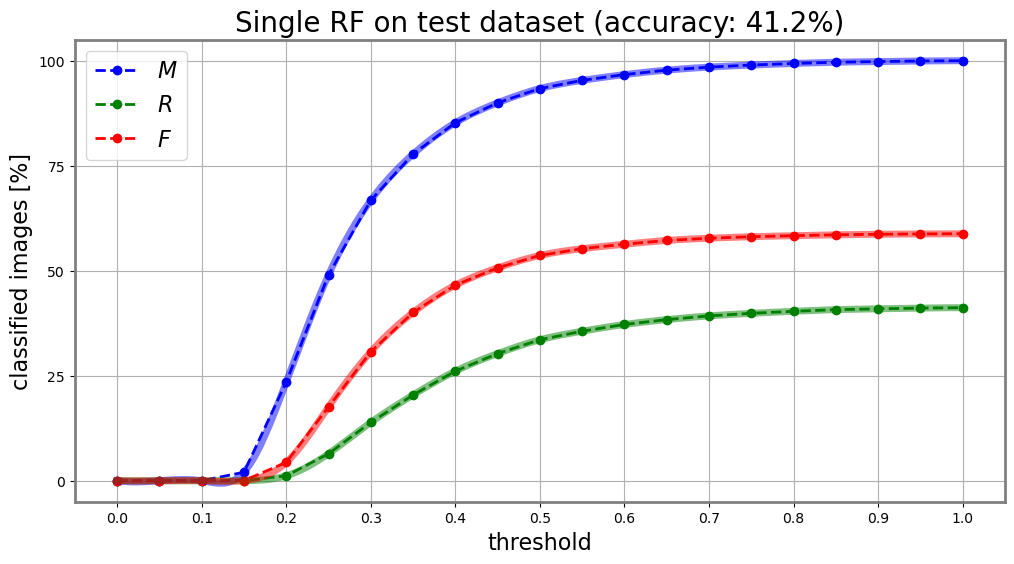

In [9]:
main(test_data, 'test')

accuracy:		1.0		<class 'numpy.float64'>
predictions:		(50000,)		<class 'numpy.ndarray'>
relative predictions:	(50000, 10)	<class 'numpy.ndarray'>
ensemble prediction:	(50000,)		<class 'numpy.ndarray'>
ensemble confidence:	(50000,)		<class 'numpy.ndarray'>


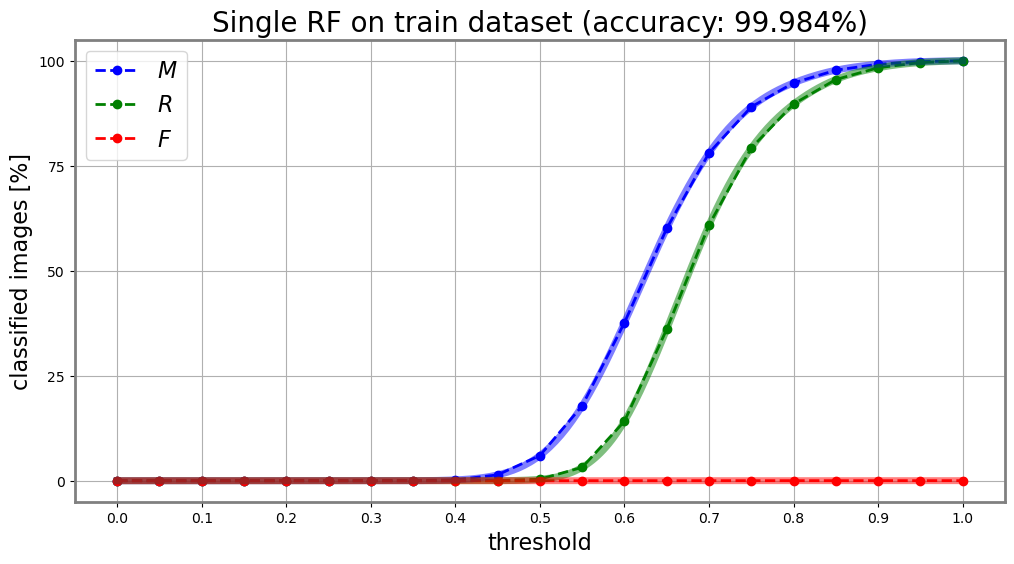

In [10]:
main(train_data, 'train')